INstallation du client PROCGEN

In [1]:
!pip install procgen

In [19]:
import torch
from procgen import ProcgenEnv
from procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame
import imageio
from IPython.display import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Instanciation of the environment

In [7]:
env = ProcgenEnv(
        num_envs=1,
        env_name="fruitbot",
        start_level=0,
        num_levels=100,
        distribution_mode='easy',
    )

env = VecExtractDictObs(env, "rgb")
env = TransposeFrame(env)
env = ScaledFloatFrame(env)

The Agent class is defined in the agent.py file.
An agent is composed of a feature extractor and a policy. The feature extractor is a neural network that takes the image as input and outputs a vector of features. The policy is a neural network that takes the features as input and outputs a score for each action. The action with the highest score is the one that is chosen.

You can use it as follows:

In [8]:
from agent import Agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=torch.device('cpu')
agent = Agent()
agent.load_state_dict(torch.load('agent_weights.pth', map_location=device))
agent.eval()

Agent(
  (features): ImpalaModel(
    (block1): ImpalaBlock(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (res1): ResidualBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (res2): ResidualBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (block2): ImpalaBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (res1): ResidualBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 32, kernel_size=(

The following code shows how to use the agent to play a game

In [9]:
obs = env.reset()

while True:
    obs = torch.FloatTensor(obs).to(device)
    action = agent(obs).argmax(1).cpu().numpy()
    obs, _, done ,_ = env.step(action)
    if done[0]:
        break

env.close()

## Code to record a gif

note : "fps" has been replaced by "duration" because fps is not supported anymore. 

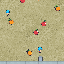

In [40]:
def obs_to_image(obs):
  return (obs[0].transpose(1,2,0) * 255).astype(np.uint8)


def display_trajectory(frames, duration=5):
  imageio.mimwrite('./tmp.gif',
                [obs_to_image(frame) for i, frame in enumerate(frames)],
                duration=duration)
  return(Image(open('tmp.gif','rb').read(), width=500, height=500))


frames = []
obs = env.reset()

while True:
    frames.append(obs)
    #obs = torch.FloatTensor(obs).to('cuda')   #code déjà dans la focntion "play"
    #action = agent(obs).argmax(1).cpu().numpy()   #code déjà dans la focntion "play"
    obs, _, done ,_ = env.step(action)
    img = env.render()
    if done[0]:
        break

env.close()

display_trajectory(frames)


## Objectives - Subject
You can use the tools seen in the course, and you can also use other tools if you want. You are expected to produce three types of explanations.
Don't be surprised if some methods don't work well on every frame (like grad-CAM), it is normal.

### Model VGG11 pretrained loading

In [11]:
import torch.nn as nn
import torch
import torchvision

model = torchvision.models.vgg11(pretrained=True)
for param in model.features:
    param.requires_grad = False

model.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=10, bias=True),
        )

model = model.to(device)
model.eval()

c:\Users\greg\anaconda3\envs\iaf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\greg\anaconda3\envs\iaf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

## LIME

In [23]:
!pip install lime

     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/275.7 kB ? eta -:--:--
     -------- ---------------------------- 61.4/275.7 kB 544.7 kB/s eta 0:00:01
     ---------------- ------------------- 122.9/275.7 kB 901.1 kB/s eta 0:00:01
     -------------------------- ----------- 194.6/275.7 kB 1.2 MB/s eta 0:00:01
     ----------------------------- ------ 225.3/275.7 kB 981.9 kB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283842 sha256=3a46d369f2f88568d2e3da1dfcb90ce1d4cbf7ab60c4b21cf8861f2bc0a16c24
  Stored in directory: c:\users\greg\appdata\local\pip\cache\wheels\ed\d7\c9\5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [20]:

means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
lime_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ])

def batch_predict(images):
  with torch.no_grad():
    model.eval()
    batch = torch.stack(tuple(lime_transform(i) for i in images), dim=0)

    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch = batch.to(device)
    logits = model(batch)
  return logits.detach().cpu().numpy()

In [28]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import imageio
import logging

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

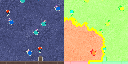

In [41]:
# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

composite_frames = []

for frame in frames:
    rgb_frame = obs_to_image(frame)
    explanation = explainer.explain_instance(rgb_frame, 
                                            batch_predict, 
                                            top_labels=5, 
                                            hide_color=0, 
                                            num_samples=1000)
        
    # Get image and mask for the top label
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=False, 
                                                num_features=10, 
                                                hide_rest=False)
        
    # Mark the boundaries on the image
    img_boundry = mark_boundaries(temp / 255.0, mask)
    
    composite_image = np.hstack((rgb_frame, img_boundry))

    # Add the composite frame to the list
    composite_frames.append(composite_image)

#imageio.mimsave('composite_gameplay.gif', composite_frames, duration=20)
    
def display_trajectory(frames, duration=5):
    # Convert frames to 8-bit unsigned integers
    converted_frames = [(frame * 255).astype(np.uint8) if frame.dtype == np.float64 else frame for frame in frames]

    imageio.mimwrite('./tmp.gif',
                     converted_frames,  # Use the converted frames
                     duration=duration)
    return Image(open('tmp.gif', 'rb').read(), width=500, height=500)

display_trajectory(composite_frames, duration=5)


### Vanilla gradient back-propagation

We will now implement three methods to generate saliency maps on our images.  
One of the simplest ways to generate saliency maps is certainly to backpropagate the gradients of the predicted output directly to the image input.  This method, called vanilla gradient backpropagation, is presented in this [article](Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps).

Let's first visualize an image for which we will generate a saliency map according to our model's prediction.

In [46]:
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(means, stds)],
   std= [1/s for s in stds]
)

In [54]:
means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

# Move the model to GPU and set it to evaluation mode
model.to(device).eval()

saliency_maps = []

for frame in frames:
    rgb_frame = obs_to_image(frame)
    
    
    print("input shape",frame.ndim())
    # Check if the frame is already a tensor in the correct shape
    if isinstance(frame, torch.Tensor) and frame.shape == (1, 3, 64, 64):
        frame_tensor = frame.to(device)
    elif isinstance(frame, np.ndarray) and frame.ndim == 3 and frame.shape[2] == 3:
        # Convert and transform the frame
        frame_tensor = transform(frame).unsqueeze(0).to(device)
    else:
        raise ValueError("Frame must be a numpy array with shape (H, W, 3) or a tensor with shape (1, 3, 64, 64)")

    # Enable gradients for the input
    frame_tensor.requires_grad_()

    # Forward pass
    output = model(frame_tensor)
    output_idx = output.argmax()
    output_max = output[0, output_idx]

    # Backward pass
    model.zero_grad()
    output_max.backward()

    # Generate saliency map
    saliency, _ = torch.max(frame_tensor.grad.data.abs(), dim=1)
    saliency = saliency.squeeze(0).cpu().numpy()
    saliency_maps.append(saliency)

    # Clear gradients for the next iteration
    frame_tensor.grad.data.zero_()

# Visualize the original frames and their saliency maps
num_frames = len(frames)
plt.figure(figsize=(30, 10 * num_frames))

for i in range(num_frames):
    plt.subplot(num_frames, 2, 2*i + 1)
    plt.imshow(frames[i])
    plt.axis('off')
    plt.subplot(num_frames, 2, 2*i + 2)
    plt.imshow(saliency_maps[i], cmap='hot')
    plt.axis('off')

plt.tight_layout()
plt.show()

TypeError: 'int' object is not callable

In [50]:
means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

# Move the model to GPU and set it to evaluation mode
model.to(device).eval()

saliency_maps = []

for frame in frames:
    print("frame shape",frame.shape)
    # Ensure frame is a numpy array and has the right shape
    if isinstance(frame, np.ndarray) and frame.ndim == 3 and frame.shape[2] == 3:
        frame_tensor = transform(frame).unsqueeze(0).to(device)
    else:
        raise ValueError("Frame must be a numpy array with shape (H, W, 3)")

    # Enable gradients for the input
    frame_tensor.requires_grad_()

    # Forward pass
    output = model(frame_tensor)
    output_idx = output.argmax()
    output_max = output[0, output_idx]

    # Backward pass
    model.zero_grad()
    output_max.backward()

    # Generate saliency map
    saliency, _ = torch.max(frame_tensor.grad.data.abs(), dim=1)
    saliency = saliency.squeeze(0).cpu().numpy()
    saliency_maps.append(saliency)

    # Clear gradients for the next iteration
    frame_tensor.grad.data.zero_()

# Visualization code...
# Visualize the original frames and their saliency maps
num_frames = len(frames)
plt.figure(figsize=(30, 10 * num_frames))

for i in range(num_frames):
    plt.subplot(num_frames, 2, 2*i + 1)
    plt.imshow(frames[i])
    plt.axis('off')
    plt.subplot(num_frames, 2, 2*i + 2)
    plt.imshow(saliency_maps[i], cmap='hot')
    plt.axis('off')

plt.tight_layout()
plt.show()

frame shape (1, 3, 64, 64)


ValueError: Frame must be a numpy array with shape (H, W, 3)

In [48]:
means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

# Move the model to GPU and set it to evaluation mode
model.to(device).eval()

saliency_maps = []
for frame in frames:
    #rgb_frame = obs_to_image(frame)
    np_img = np.transpose(inv_normalize(img).cpu().detach().numpy(), (1,2,0))

    frame = transform(frame).unsqueeze(0).to(device)

    # Enable gradients for the input
    frame.requires_grad_()

    # Forward pass
    output = model(frame)
    output_idx = output.argmax()
    output_max = output[0, output_idx]

    # Backward pass
    model.zero_grad()
    output_max.backward()

    # Generate saliency map
    saliency, _ = torch.max(frame.grad.data.abs(), dim=1)
    saliency = saliency.squeeze(0).cpu().numpy()
    saliency_maps.append(saliency)

    # Optional: Clear gradients for the next iteration
    frame.grad.data.zero_()

# Visualize the original frames and their saliency maps
num_frames = len(frames)
plt.figure(figsize=(30, 10 * num_frames))

for i in range(num_frames):
    plt.subplot(num_frames, 2, 2*i + 1)
    plt.imshow(frames[i])
    plt.axis('off')
    plt.subplot(num_frames, 2, 2*i + 2)
    plt.imshow(saliency_maps[i], cmap='hot')
    plt.axis('off')

plt.tight_layout()
plt.show()

ValueError: axes don't match array

In [ ]:
import numpy as np

x, _ = next(iter(trainloader))
idx = 0

img = x[idx]
np_img = np.transpose(inv_normalize(img).cpu().detach().numpy(), (1,2,0))
plt.imshow(np_img)
plt.axis('off')

In [ ]:
img = img.unsqueeze(0).to(device)    #.cuda() # we need to set the input on GPU before the requires_grad operation!
img.requires_grad_();

We will now compute the model's prediction for this image and backpropagate from this prediction to the image.

In [ ]:
output = model(img)
output_idx = output.argmax()
output_max = output[0, output_idx]

output_max.backward()

In [ ]:
saliency, _ = torch.max(img.grad.data.abs(), dim=1)
saliency = saliency.squeeze(0)


plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(np_img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(saliency.cpu(), cmap='hot')
plt.axis('off')

### Smooth grad
A simple way to generate smoother visualizations called [Smooth-grad](https://arxiv.org/pdf/1706.03825.pdf) consists of averaging saliency maps from augmented versions of the original image.  
Complete the following function to generate the gradient of an image according to the model's prediction.

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

def get_smoothed_gradients(img, model, stdev_spread=0.15, n_samples=100):
    stdev = stdev_spread * (img.max() - img.min())
    total_gradients = torch.zeros_like(img, device=device)

    for i in range(n_samples):
        noise = np.random.normal(0, stdev.item(), img.shape).astype(np.float32)
        noisy_img = img + torch.tensor(noise, device=device, requires_grad=True)
        noisy_img.retain_grad()

        output = model(noisy_img)
        output_idx = output.argmax()
        output_max = output[0, output_idx]
        output_max.backward()

        grad = noisy_img.grad.data
        total_gradients += grad * grad  # Square of gradients for smoother visualization

    total_gradients /= n_samples
    return total_gradients

# Assuming 'frames' is your list of frames
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

saliency_maps = []

for np_frame in frames:
    img = transform(np_frame).unsqueeze(0).to(device)
    smoothed_gradients = get_smoothed_gradients(img, model)
    saliency, _ = torch.max(smoothed_gradients.abs(), dim=1)
    saliency = saliency.squeeze(0).cpu().numpy()
    saliency_maps.append(saliency)

# Visualization
num_frames = len(frames)
plt.figure(figsize=(30, 10 * num_frames))

for i in range(num_frames):
    plt.subplot(num_frames, 2, 2*i + 1)
    plt.imshow(frames[i])
    plt.axis('off')
    plt.subplot(num_frames, 2, 2*i + 2)
    plt.imshow(saliency_maps[i], cmap='hot')
    plt.axis('off')

plt.tight_layout()
plt.show()


ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

In [ ]:
def get_vanilla_grad(img, model):
  img.retain_grad()
  output = model(img)
  output_idx = output.argmax()
  output_max = output[0, output_idx]
  output_max.backward()

  return img.grad

We will now generate perturbated versions of the image by adding a gaussian noise to the original image.  
For every image generated we will compute the corresponding gardients and average them to generate the final saliency map.

In [ ]:
import numpy as np

stdev_spread=0.15
n_samples=100
stdev = stdev_spread * (img.max() - img.min())
total_gradients = torch.zeros_like(img, device='cuda')

for i in range(n_samples):
    noise = np.random.normal(0, stdev.item(), img.shape).astype(np.float32)
    noisy_img = img + torch.tensor(noise, device='cuda', requires_grad=True)
    grad= get_vanilla_grad(noisy_img, model)
    total_gradients += grad * grad #using the square of the gradients generates smoother visualizations
    #total_gradients += grad
total_gradients /= n_samples

saliency, _ = torch.max(total_gradients.abs(), dim=1)
saliency = saliency.squeeze(0)


plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(np_img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(saliency.cpu(), cmap='hot')
plt.axis('off')

### Grad-CAM
Instead of propagating the gradients to the inputs, the [Grad-CAM](https://arxiv.org/abs/1610.02391) method generates a saliency map by multiplying the outputs of the final feature map with an average of its gradients.  It thus generates coarse saliency maps, sometimes more relevant than pixels.  
We will create a 'hook' to keep both the activations and the gardients of a network layer.  
This operation is a bit tricky, just keep it mind that it is a way to keep activations and gradients in a single object during the forward and the backward pass.

In [ ]:
class HookFeatures():
    def __init__(self, module):
        self.feature_hook = module.register_forward_hook(self.feature_hook_fn)
    def feature_hook_fn(self, module, input, output):
        self.features = output.clone().detach()
        self.gradient_hook = output.register_hook(self.gradient_hook_fn)
    def gradient_hook_fn(self, grad):
        self.gradients = grad
    def close(self):
        self.feature_hook.remove()
        self.gradient_hook.remove()

In [ ]:
print(model)
hook = HookFeatures(model.features[19])

Similar to what we did before, we will backpropagate the gradients of the predicted output on the feature map this time and get both the activations and the gradients thanks to our hook on the last convolutional layer.

In [ ]:
output = model(img)
output_idx = output.argmax()
output_max = output[0, output_idx]
output_max.backward()

gradients = hook.gradients
activations = hook.features
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) # we take the average gradient of every chanels
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i] # we multiply every chanels of the feature map with their corresponding averaged gradients

We can now take the average of all channels of the gradient weighted feature map to generate a heat map, keeping only the positive values to get the positive influences only.  
We also need to reshape the generated heat map to math the original input size.

In [ ]:
import cv2

heatmap = torch.mean(activations, dim=1).squeeze()
heatmap = np.maximum(heatmap.detach().cpu(), 0)
heatmap /= torch.max(heatmap)
heatmap = cv2.resize(np.float32(heatmap), (img.shape[2], img.shape[3]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW) / 255
superposed_img = (heatmap) * 0.4 + np_img
plt.figure(figsize=(8,8))
plt.imshow(np.clip(superposed_img,0,1))
plt.axis('off')

## Captum

In [ ]:
!pip install captum

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import GuidedGradCam
from captum.attr import DeepLift
from captum.attr import visualization as viz

In [ ]:
def plot_heatmap(attributions, img):
  _ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                              np.transpose(inv_normalize(img).squeeze().cpu().detach().numpy(), (1,2,0)),
                              methods=["original_image", "heat_map"],
                              signs=['all', 'positive'],
                              cmap='hot',
                              show_colorbar=True)

# Integradted gradients (https://arxiv.org/abs/1703.01365)
integrated_gradients = IntegratedGradients(model)
attributions = integrated_gradients.attribute(img, target=output_idx, n_steps=200, internal_batch_size=1)

plot_heatmap(attributions, img)